# Which City has the best Night clubs? Las Vegas? Miami? New York city?

We all know **Las Vegas**, **New York City**, and **Miami** are the most popular tourist destinations among others in the USA.Each place is unique and known for its own attraction.

**The entertainment capital of the world** LAS VEGAS is known for its gambling, shopping, fine dining, entertainment, and nightlife.The major attraction in Las Vegas are the casinos and the hotels and each casino have their own nightclubs. 

**The city that never sleeps** NEW YORK is known for many Broadway theaters, cinemas, and electronic billboards and nightlife. It got some of the world's most famous bars, music clubs, and night clubs. 

**Miami** South Beach is home to some of the most beautiful beaches and outstanding nightclubs in the country. 
The city attracts the second-highest number of foreign tourists of any city in the United States, after New York City.

Let explore the nightlife of these 3 cities and find out which city has the best Night Clubs. 
I will be using *FourSquare* API to get the list of NightClubs and their details which include rating, likes, price, tips. 

## Importing all required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

print('All Libraries imported.')

All Libraries imported.


## Pass FourSquare API

In [2]:
CLIENT_ID = '2UD1WZDJ1TQISPF0UQIJVSHLG4HE1TQ005KWJMJ30UC1LNZV' 
CLIENT_SECRET = 'NSJHOA4G3VJSK4N4FKT1ZZCYMD3KRTN3DDRCQ0M4ZEBASUTW' 
VERSION = '20200427' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2UD1WZDJ1TQISPF0UQIJVSHLG4HE1TQ005KWJMJ30UC1LNZV
CLIENT_SECRET:NSJHOA4G3VJSK4N4FKT1ZZCYMD3KRTN3DDRCQ0M4ZEBASUTW


### Searching for Nightclubs with in 25 miles of the city.

In [3]:
limit = 1000
radius= 50000 # in meters
search_query=['club']



In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Function takes the city parameter and produces city's Nightclubs data

In [5]:
def get_venue_data(city):
    address = city
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latitude, 
        longitude, 
        VERSION, 
        search_query,
        radius, 
        limit)
    
    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']

    
    df_name = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
    df_name =df_name.loc[:, filtered_columns]

    # filter the category for each row
    df_name['venue.categories'] = df_name.apply(get_category_type, axis=1)

    # clean columns
    df_name.columns = [col.split(".")[-1] for col in df_name.columns]

    return df_name



### Calling the function for each city.

In [6]:
newyork = get_venue_data('New York,NY')

In [7]:
vegas = get_venue_data('Las Vegas,NV')

In [8]:
miami = get_venue_data('Miami,FL')

### Sticking to just NightClubs data

In [9]:
club_miami = miami[miami['categories'].str.lower().str.contains('club')]

In [10]:
club_vegas = vegas[vegas['categories'].str.lower().str.contains('club')]

In [11]:
club_ny = newyork[newyork['categories'].str.lower().str.contains('club')]

In [91]:
club_miami.head()

,name,categories,lat,lng,id
0,LIV Miami,Nightclub,25.817668,-80.122602,4b10c7f8f964a520ae7523e3
1,E11even Miami,Nightclub,25.785052,-80.193544,52c6105f498e18a92fe484d3
2,STORY Nightclub,Nightclub,25.770619,-80.133859,50a4a5e0e4b05d87e6525260
3,Club Space,Nightclub,25.784535,-80.193177,4043ce80f964a52019f21ee3
4,Treehouse Miami,Nightclub,25.799039,-80.129512,4d115d5b99b78cfa918ac9d5


### Function to add venue details like rating, price,likes,tips to the original dataframe

In [13]:
def add_newcolumns(df_name):
    cols = df_name.columns.values.tolist() + ['rating','price','likes','tips']
    
    new_df = pd.DataFrame(columns=cols)
    new_df['name'] = df_name['name']
    

    for r in np.arange(df_name.shape[0]):
        venue_id = df_name.iloc[r,-1]
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        details = result['response']['venue']
        df = pd.json_normalize(details)
        # checking if rating exists
        if 'rating' in df.columns:
            rating = df['rating'].values[0]
        else:
            rating = 0 
        # checking if price exits    
        if 'price.message' in df.columns:
            price = df['price.message'].values[0]
        else:
            price = 'NaN'
        # checking if likes exits 
        if 'likes.count' in df.columns:
            likes = df['likes.count'].values[0]
        else:
            likes = 0
            
        # checking if tips exits 
        if 'tips.count' in df.columns:
            tips = df['tips.count'].values[0]
        else:
            tips = 0
        
            
        #new_data = df[['rating','price.message','likes.count','tips.count']].values.tolist()[0]
        new_data = [rating,price,likes,tips]
        new_df.iloc[r,1:] = np.array(df_name.iloc[r,1:].values.tolist()+new_data).reshape(1,8)
        
    return new_df
    

 


In [14]:
club_miami_new = add_newcolumns(club_miami)

In [16]:
club_ny_new = add_newcolumns(club_ny)

In [15]:
club_vegas_new = add_newcolumns(club_vegas)

### Funtion to change datatypes to float and int

In [39]:
# Columns to change data types to int
#C = ['rating', 'likes', 'tips']
def change_datatype(df_name,col_list):
    for col in col_list:
        if col == 'rating':
            df_name.loc[:,col] = df_name[col].astype(float)
        else:
            df_name.loc[:,col] = df_name[col].astype(int)
    return df_name

In [40]:
club_vegas_new = change_datatype(club_vegas_new,['rating', 'likes', 'tips'])
club_ny_new = change_datatype(club_ny_new,['rating', 'likes', 'tips'])
club_miami_new = change_datatype(club_miami_new,['rating', 'likes', 'tips'])

### Lets explore only the Top 25 Night Clubs from each city.

In [41]:
top_25_ny = club_ny_new[(club_ny_new.rating>6.5)&(club_ny_new.categories=='Nightclub')].sort_values('rating',ascending=False).head(25)

In [42]:
top_25_miami = club_miami_new[(club_miami_new.rating>6.5)&(club_miami_new.categories=='Nightclub')].sort_values('rating',ascending=False).head(25)

In [43]:
top_25_vegas = club_vegas_new[(club_vegas_new.rating>6.5)&(club_vegas_new.categories=='Nightclub')].sort_values('rating',ascending=False).head(25)

In [92]:
top_25_vegas.head()

,name,categories,lat,lng,id,rating,price,likes,tips
0,Encore Beach Club,Nightclub,36.12940027183192,-115.16608357429504,4bf6c3745efe2d7f2ab46734,9.5,Very Expensive,1081,87
10,Mandalay Resort & Casino Beach Club,Nightclub,36.08963775939128,-115.17303756566388,4dd082aeb0fb25f6e3772861,9.0,Expensive,60,5
11,Foundation Room,Nightclub,36.09183,-115.174871,4b025c33f964a520714822e3,8.8,Expensive,233,75
4,1 OAK Nightclub,Nightclub,36.122136568410696,-115.1741335677233,4e6a696a7d8b143eb718eef5,8.6,Very Expensive,569,87
2,OMNIA Nightclub,Nightclub,36.11735959268146,-115.17410714229834,54ffb470498ef3f03868aed6,8.5,Very Expensive,870,115


### Hot Encoding the price column to get the numeric values.

In [49]:
ny_hot = pd.get_dummies(top_25_ny.set_index('name')[['rating','likes','tips','price']])
miami_hot = pd.get_dummies(top_25_miami.set_index('name')[['rating','likes','tips','price']])
vegas_hot = pd.get_dummies(top_25_vegas.set_index('name')[['rating','likes','tips','price']])

In [93]:
vegas_hot.head()

,rating,likes,tips,price_Cheap,price_Expensive,price_Moderate,price_Very Expensive
name,,,,,,,
Encore Beach Club,1.000000,0.697419,0.260479,0,0,0,1
Mandalay Resort & Casino Beach Club,0.947368,0.038710,0.014970,0,1,0,0
Foundation Room,0.926316,0.150323,0.224551,0,1,0,0
1 OAK Nightclub,0.905263,0.367097,0.260479,0,0,0,1
OMNIA Nightclub,0.894737,0.561290,0.344311,0,0,0,1


### Function to normalize the numeric values applies to rating, likes, tips columns

In [51]:
def normalize_data(df_name,col_list):
    for col in col_list:
        df_name.loc[:,col] = df_name[col]/df_name[col].max()
    return df_name

ny_hot = normalize_data(ny_hot,['rating', 'likes', 'tips'])
miami_hot = normalize_data(miami_hot,['rating', 'likes', 'tips'])
vegas_hot = normalize_data(vegas_hot,['rating', 'likes', 'tips'])

In [94]:
r1 = ny_hot.mean(1).mean(),miami_hot.mean(1).mean(),vegas_hot.mean(1).mean()
df1 = pd.DataFrame(r1,index=['NY','Miami','Vegas'],columns = ['Clubs mean score'])
df1

,Clubs mean score
NY,0.322070
Miami,0.393321
Vegas,0.336654


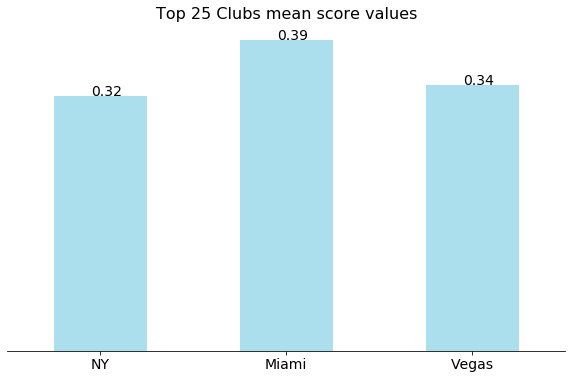

In [153]:
%matplotlib inline
import matplotlib.pyplot as plt
xlabels = df1.index.values.tolist()
ax = df1.plot(kind='bar',figsize=(10,6),alpha=0.5,color='#5bc0de')

for p in ax.patches:
    value = '{:.2f}'.format(p.get_height())
    width,height = p.get_width(),p.get_height()
    x=p.get_x()+width-0.3
    y=p.get_y()+height+0.001
    ax.annotate(value,(x,y),fontsize=14)
    


ax.get_yaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Top 25 Clubs mean score values',fontsize=16)
ax.get_legend().remove()
ax.set_xticklabels(xlabels,fontsize=14,rotation=0);


As we can see **Miami** got the best clubs as per above data followed by **Vegas** and **New York city**.  
**Note:** Here we are including clubs rating, likes, price and tips (Data from FourSquare API)

### Lets explore the clubs by looking at all factors i,e rating, likes, tips & price.

In [182]:
df2 = pd.DataFrame(ny_hot.mean(),columns=['NY']).T.rename(columns={'price_Cheap':'Cheap','price_Expensive':'Expensive','price_Moderate':'Moderate','price_Very Expensive':'Very Expensive','rating':'Rating','likes':'Likes','tips':'Tips'})
df3 = pd.DataFrame(miami_hot.mean(),columns=['Miami']).T.rename(columns={'price_Cheap':'Cheap','price_Expensive':'Expensive','price_Moderate':'Moderate','price_Very Expensive':'Very Expensive','rating':'Rating','likes':'Likes','tips':'Tips'})
df4 = pd.DataFrame(vegas_hot.mean(),columns=['Vegas']).T.rename(columns={'price_Cheap':'Cheap','price_Expensive':'Expensive','price_Moderate':'Moderate','price_Very Expensive':'Very Expensive','rating':'Rating','likes':'Likes','tips':'Tips'})
frames =[df2,df3,df4]
df5 = pd.concat(frames)

In [207]:
df5.head()

,Rating,Likes,Tips,Cheap,Expensive,Moderate,Very Expensive
NY,0.894505,0.190584,0.169398,0.08,0.44,0.32,0.16
Miami,0.932273,0.251393,0.176258,NaN,0.44,0.40,0.16
Vegas,0.833684,0.251277,0.271617,0.04,0.56,0.12,0.28


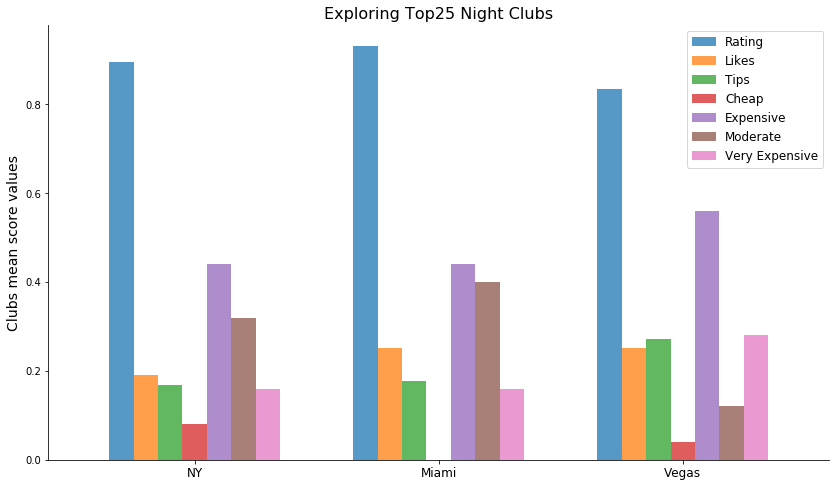

In [208]:
ax = df5.plot(kind='bar',figsize=(14,8),alpha=0.75,width=0.7)
ax.set_ylabel('Clubs mean score values',fontsize=14)
ax.set_xticklabels(xlabels,fontsize=12,rotation=0)
ax.set_title('Exploring Top25 Night Clubs',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=12);


Based on the above chart.   
**Expensive and Very Expensive Clubs:** Vegas, NY, Miami  
**Rating:** Miami, NY, Vegas  
**Likes:** Vegas and Miami got almost same likes followed by NY  
**Tips:** Vegas, Miami, NY 

## Lets look at those Top 25 Night Clubs from Miami

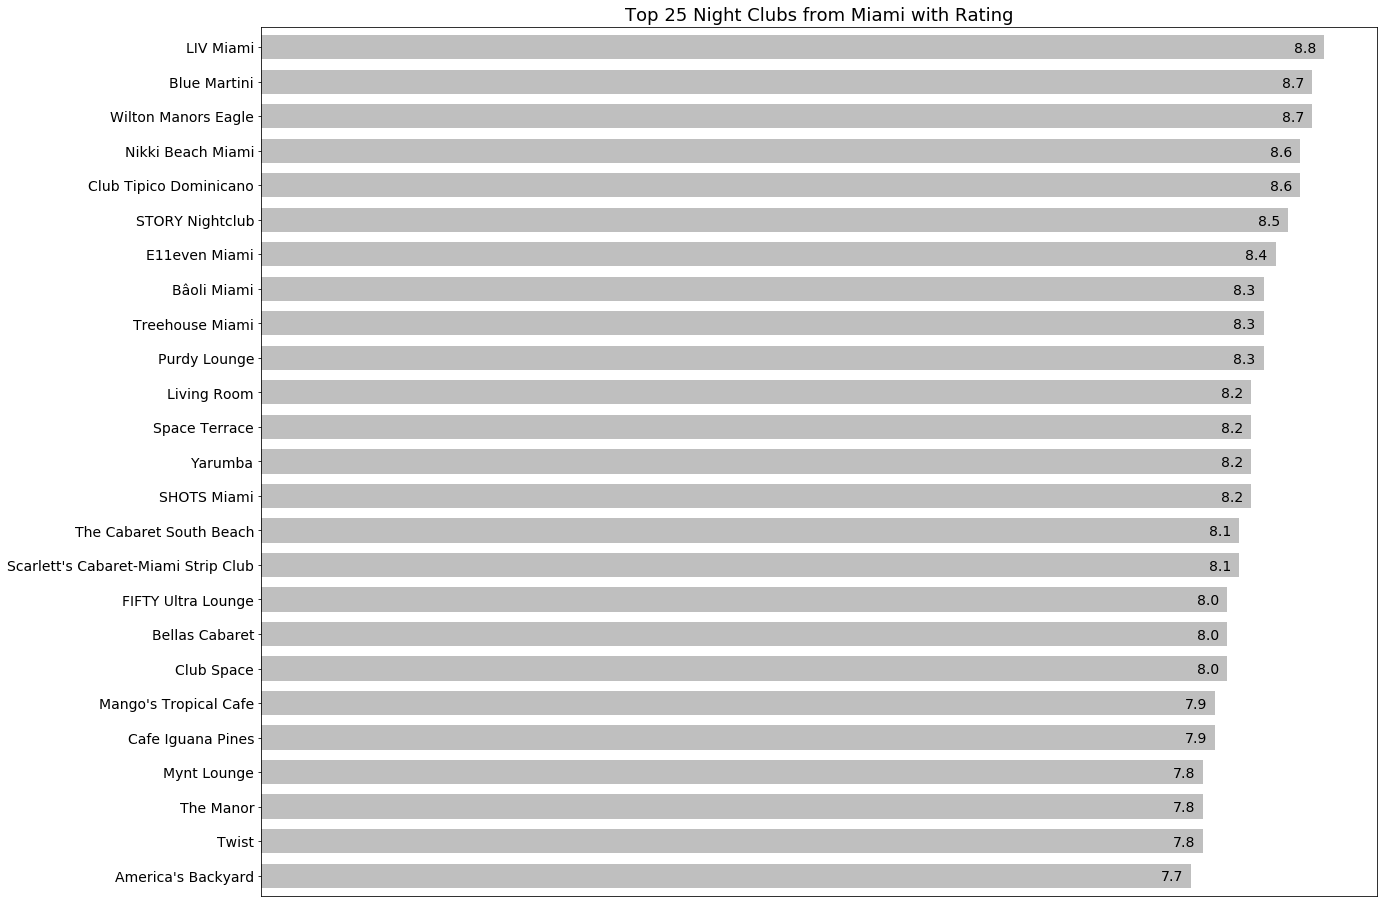

In [271]:

df6 = top_25_miami.sort_values('rating').set_index('name')['rating']
y_labels = df6.index.values.tolist()
ax = df6.plot(kind='barh',figsize=(20,16),width=0.7,alpha=0.5,color='grey')

for p in ax.patches:
    value = '{:.1f}'.format(p.get_width())
    width,height = p.get_width(),p.get_height()
    x=p.get_x()+width-0.25
    y=p.get_y()+height-0.5
    ax.annotate(value,(x,y),fontsize=14)

ax.set_xlabel('Rating',fontsize=14)
ax.set_title('Top 25 Night Clubs from Miami with Rating', fontsize=18)
ax.set_ylabel('')
ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_yticklabels(y_labels,fontsize=14);




In [302]:
def replace_price(price):
    if price=='Very Expensive':
        return 3
    elif price=='Expensive':
        return 2
    else:
        return 1


In [312]:
geo_miami = top_25_miami[['name','lat','lng','rating','price']]
geo_miami.loc[:,'price'] = geo_miami.loc[:,'price'].apply(lambda x:replace_price(x))

price_range = geo_miami['price'].max()
geo_miami.loc[:,'lat']=geo_miami.loc[:,'lat'].astype(float)
geo_miami.loc[:,'lng']=geo_miami.loc[:,'lng'].astype(float)
#top_25_miami

C:\Users\thamats\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [308]:
# Getting Totonto lat and long values.
address = 'Miami,Florida'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Miami are {}, {}.'.format(latitude, longitude))
map_miami = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(1,price_range+1)
ys = [i + x + (i*x)**2 for i in range(price_range)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, rating,club,price in zip(geo_miami['lat'], geo_miami['lng'], geo_miami['rating'], geo_miami['name'],geo_miami['price']):
    label = folium.Popup(club + ' Rating - ' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color='blue',
        color=rainbow[price-1],
        fill=True,
        #fill_color='#3186cc',
        fill_color=rainbow[price-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)
    
map_miami

## Conclusion

After exploring the above data. It's Noticeable that **Miami** has the best Night Clubs when compared to **Vegas** and **NY**.  
May be Vegas Night Clubs has to bring down their prices to get better ratings.